In [1]:
import import_ipynb
import Extract_Python_Pairs as EPP
import Python_tokenizer

import io
from tqdm import tqdm
import collections
import numpy as np
import os

#TENSORFLOW
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,  Embedding, LSTM, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

import pydot
import graphviz
import matplotlib.pyplot as plt
from keras.utils import plot_model

importing Jupyter notebook from Extract_Python_Pairs.ipynb
importing Jupyter notebook from Python_tokenizer.ipynb


In [2]:
#get the code and comment snippets from the Extract Python Pairs file
code_snippets, comments = EPP.get_python_pairs(EPP.get_all_data())

  0%|          | 17907/16115540 [00:00<01:29, 179068.04it/s]

Completed in 414 seconds


100%|██████████| 16115540/16115540 [01:19<00:00, 201726.29it/s]


Total pairs: 2508330


In [4]:
#filter out code pairs which will throw errors during tokenization
clean_code,clean_comments = Python_tokenizer.clean_pairs(code_snippets[:2000], comments[:2000])

100%|██████████| 2000/2000 [00:01<00:00, 1271.33it/s]

failed: 0.022 %
number of clean pairs: 1956


In [5]:
num_samples = 1000
vocab_size = 1000

In [6]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

def tokenize_comment(x):
    x_tk = Tokenizer(char_level = False, num_words=vocab_size)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

def tokenize_code(x):
    x_tk = Python_tokenizer.Python_Tokenizer(num_words=vocab_size)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [7]:
def preprocess(code, comment):
    preprocess_x, x_tk = tokenize_code(code)
    preprocess_y, y_tk = tokenize_comment(comment)
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    return preprocess_x, preprocess_y, x_tk, y_tk


preproc_code_snippets, preproc_english_comments, code_tokenizer, comment_tokenizer = preprocess(clean_code[:num_samples], clean_comments[:num_samples])

max_code_sequence_length = preproc_code_snippets.shape[1]
max_comment_sequence_length = preproc_english_comments.shape[1]
code_vocab_size = len(code_tokenizer.word_index)
comment_vocab_size = len(comment_tokenizer.word_index)


print('Data Preprocessed')
print("Max code sentence length:", max_code_sequence_length)
print("Max comment sentence length:", max_comment_sequence_length)
print("code vocabulary size:", code_vocab_size)
print("comment vocabulary size:", comment_vocab_size)

100%|██████████| 1000/1000 [00:00<00:00, 1317.30it/s]


Data Preprocessed
Max code sentence length: 246
Max comment sentence length: 140
code vocabulary size: 2522
comment vocabulary size: 2384


In [8]:
# list all data in history
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

Epoch 1/25
80/80 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.4824
Epoch 00001: val_loss improved from inf to 0.14259, saving model to code2comment_models/bi_lstm.ckpt
80/80 [==============================] - 19s 238ms/step - loss: 0.1614 - accuracy: 0.4824 - val_loss: 0.1426 - val_accuracy: 0.6876
Epoch 2/25
80/80 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.5323
Epoch 00002: val_loss did not improve from 0.14259
80/80 [==============================] - 14s 180ms/step - loss: 0.0837 - accuracy: 0.5323 - val_loss: 0.1486 - val_accuracy: 0.6924
Epoch 3/25
80/80 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.5373
Epoch 00003: val_loss did not improve from 0.14259
80/80 [==============================] - 15s 183ms/step - loss: 0.0787 - accuracy: 0.5373 - val_loss: 0.1521 - val_accuracy: 0.6876
Epoch 4/25
80/80 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.5429
Epoch 00004: val_loss did

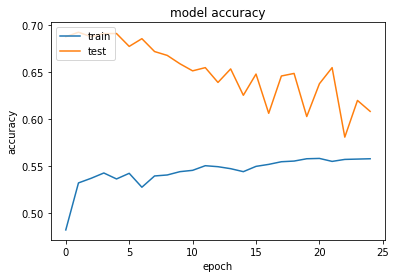

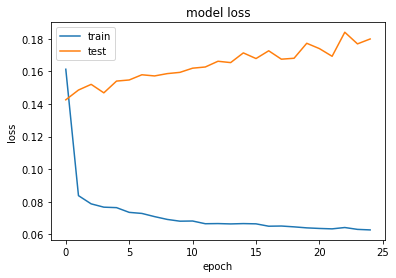

In [13]:
#define the model
def BiLSTM_model(input_shape, output_sequence_length, comment_vocab_size):
    
    learning_rate = 1e-3
    model = Sequential()
    #em can only be used in first layer --> Keras Documentation
    model.add(Embedding(comment_vocab_size, 64, input_length=input_shape[1],mask_zero=True))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation="tanh")))
    model.add(TimeDistributed(Dense(comment_vocab_size, activation="softmax")))
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model


checkpoint_path = "code2comment_models/bi_lstm.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              save_weights_only=True,
                                              save_best_only=True,
                                              verbose=1)



tmp_x = pad(preproc_code_snippets, max_comment_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_english_comments.shape[-2]))

#load the model
bilstm_model = BiLSTM_model(
    tmp_x.shape,
    max_comment_sequence_length,
    comment_vocab_size+1)


#train the model
bilstm_model_history = bilstm_model.fit(tmp_x, 
                                        preproc_english_comments, 
                                        batch_size=10, 
                                        epochs=25, 
                                        validation_split=0.2,
                                        callbacks=[callback])

#plot the model
plot_history(bilstm_model_history)


Epoch 1/25
80/80 [==============================] - ETA: 0s - loss: 2.2211 - accuracy: 0.7958
Epoch 00001: val_loss improved from inf to 1.49263, saving model to code2comment_models/GRU.ckpt
80/80 [==============================] - 51s 642ms/step - loss: 2.2211 - accuracy: 0.7958 - val_loss: 1.4926 - val_accuracy: 0.8956
Epoch 2/25
80/80 [==============================] - ETA: 0s - loss: 1.8817 - accuracy: 0.7935
Epoch 00002: val_loss improved from 1.49263 to 0.91837, saving model to code2comment_models/GRU.ckpt
80/80 [==============================] - 45s 566ms/step - loss: 1.8817 - accuracy: 0.7935 - val_loss: 0.9184 - val_accuracy: 0.9244
Epoch 3/25
80/80 [==============================] - ETA: 0s - loss: 1.7549 - accuracy: 0.8028
Epoch 00003: val_loss did not improve from 0.91837
80/80 [==============================] - 45s 557ms/step - loss: 1.7549 - accuracy: 0.8028 - val_loss: 1.1187 - val_accuracy: 0.9244
Epoch 4/25
80/80 [==============================] - ETA: 0s - loss: 1.616

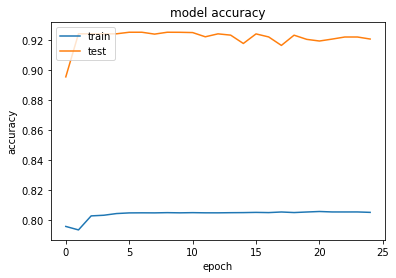

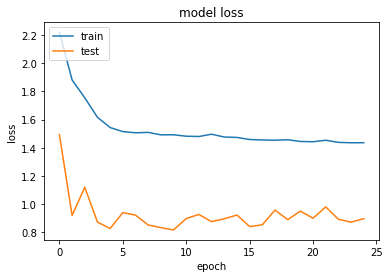

In [21]:
#https://www.tensorflow.org/guide/keras/masking_and_padding
def custom_model(input_shape, output_sequence_length, code_vocab_size, comment_vocab_size):
  
    learning_rate = 0.005
    model = Sequential()
    model.add(Embedding(input_dim=code_vocab_size,output_dim=128,input_length=input_shape[1], mask_zero=True))
    model.add(Bidirectional(GRU(256,return_sequences=False)))
    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(GRU(256,return_sequences=True)))
    model.add(TimeDistributed(Dense(comment_vocab_size,activation='softmax')))
    
    
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


checkpoint_path = "code2comment_models/GRU.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              save_weights_only=True,
                                              save_best_only=True,
                                              verbose=1)




tmp_x = pad(preproc_code_snippets, max_comment_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_english_comments.shape[-2]))


custosm = custom_model(tmp_x.shape,
                       preproc_english_comments.shape[1],
                       len(code_tokenizer.word_index)+1,
                       len(comment_tokenizer.word_index)+1)


custom_model_history = custosm.fit(tmp_x, 
                                   preproc_english_comments, 
                                   batch_size = 10, 
                                   epochs = 25, 
                                   validation_split = 0.2,
                                   callbacks=[callback])
plot_history(custom_model_history)

In [36]:
def translate(x, y, x_tk, y_tk, model, sentence):
    tmp_X = pad(preproc_code_snippets)
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'
    
    #sentence = [x_tk.word_index[word] for word in sentence.split()]
    #sentence = [x_tk.word_index[word] for word in Python_tokenizer.python_to_token_sequence(sentence)]
    s=[]
    for token in Python_tokenizer.python_to_token_sequence(sentence):
        try:
            s.append(x_tk.word_index[token])
        except:
            pass
    sentence = s
        
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentence = np.array([sentence[0], x[0]])
    
    predictions = model.predict(sentence)
    output = [y_id_to_word[np.argmax(x)] for x in predictions[0]]
    print(' '.join(output))

sentence = clean_code[910]
print('---------------------------------------------------------------')
print('Code')
print('---------------------------------------------------------------')
print(sentence)
print('---------------------------------------------------------------')
print('Output:')
print('---------------------------------------------------------------')
#m = custosm
m= bilstm_model
translate(preproc_code_snippets, preproc_english_comments, code_tokenizer, comment_tokenizer , m, sentence)
print('---------------------------------------------------------------')

---------------------------------------------------------------
Code
---------------------------------------------------------------
    def _get_mv_grid_from_bus_id(self, session, bus_id):
        

        if self._versioned is True:
            ormclass_hvmv_subst = grid.__getattribute__(
                'EgoDpHvmvSubstation'
            )
            subst_id = session.query(
                ormclass_hvmv_subst.subst_id
            ).filter(
                ormclass_hvmv_subst.otg_id == bus_id,
                ormclass_hvmv_subst.version == self._grid_version
            ).scalar()

        if self._versioned is False:
            ormclass_hvmv_subst = model_draft.__getattribute__(
                'EgoGridHvmvSubstation'
            )
            subst_id = session.query(
                ormclass_hvmv_subst.subst_id
            ).filter(
                ormclass_hvmv_subst.otg_id == bus_id
            ).scalar()

        return subst_id


-------------------------------------------